# Day 16: Decisions Under Uncertainty, Continued

---

- Broad decision strategies *under uncertainty*
  - Robust design (reduce variability)
  - Reliable design (control failure rates)
  - Nothing stopping you from combining the two!
- Decision examples


In [3]:
import pandas as pd 
import grama as gr 
import numpy as np

from scipy.stats import lognorm
from plotnine import *

DF = gr.Intention()


## DUU Strategies

---

DUU = decision under uncertainty


## Decision Examples

---


### 1. Reliable beam


In [2]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()
md_beam.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      t: [2, 4]
      w: [2, 4]

    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}

    copula:
      Independence copula

  functions:
      cross-sectional area: ['w', 't'] -> ['c_area']
      limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
      limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']



Scenario:

We have a proposed design $w = 3, t = 3$, a desired failure rate $\mathbb{P}[Failure] \leq 0.01$, and the following quantitative assessment:


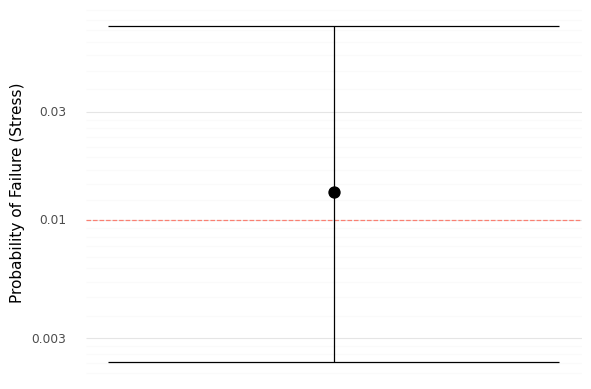

<ggplot: (8744009001226)>

In [14]:
df_design = gr.df_make(w=3.0, t=3.0)

(
    md_beam
    >> gr.ev_monte_carlo(
        df_det=df_design,
        n=75,
        seed=101,
    )
    >> gr.tf_summarize(
        pof_stress_lo=gr.binomial_ci(DF.g_stress <= 0, side="lo"),
        pof_stress_mu=gr.mean(DF.g_stress <= 0),
        pof_stress_up=gr.binomial_ci(DF.g_stress <= 0, side="up"),
    )
    
    >> ggplot(aes(x=0))
    + geom_hline(yintercept=1e-2, color="salmon", linetype="dashed")
    + geom_errorbar(aes(ymin="pof_stress_lo", ymax="pof_stress_up"))
    + geom_point(aes(y="pof_stress_mu"), size=4)
    
    + scale_x_continuous(breaks=())
    + scale_y_log10()
    + theme_minimal()
    + labs(
        x="",
        y="Probability of Failure (Stress)"
    )
)

*Questions*:
- What sources of uncertainty do you have?
  - Are they aleatory or epistemic? 
- Does this design meet the requirements?
- Which source of uncertainty is *blocking* your progress?
- What does this suggest about your next move?
  
<br>
<br>
<br>

- What sources of uncertainty do you have?
  - Inherent variability: aleatory
  - Limitations of monte carlo sample size: epistemic
  - Limitations of material model: epistemic
- Does this design meet the requirements?
  - Unknown; The CI suggests the true failure rate could meet or violate the constraint
- Which source of uncertainty is *blocking* your progress?
  - The uncertainty due to monte carlo sample size is blocking our progress
- What does this suggest about your next move?
  - The limitations of our monte carlo prevent us from concluding whether the design meets our requirements; a simple first-step would be to increase the sample size $n$. This move is suggested because 


### 2. Competing products

Suppose we're in the business of manufacturing widgets, and we want to produce the highest-performing widgets in large quantities. The widgets have a few manufacturing tolerances, which together give rise to variability in the widget performance. We're comparing a proposed new design against a competitor's design.


eval_monte_carlo() is rounding n...


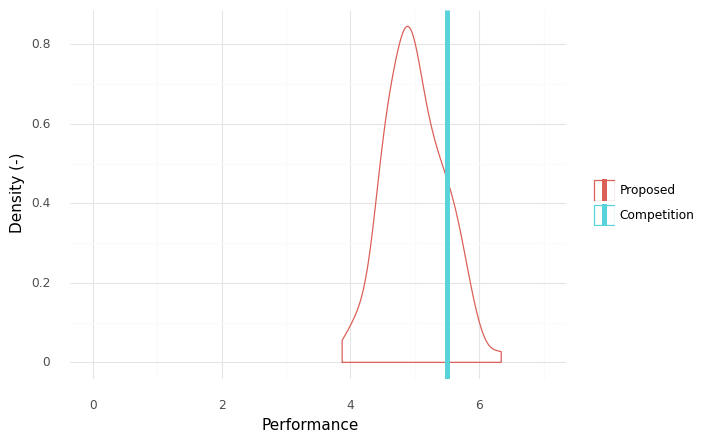

<ggplot: (8744009686917)>

In [27]:
(
    gr.Model("Manufactured part")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.a + df.b - df.c + 5),
        var=["a", "b", "c"],
        out=["f"],
    )
    >> gr.cp_marginals(
        a=dict(dist="uniform", loc=-0.5, scale=+1.0),
        b=dict(dist="uniform", loc=-0.5, scale=+1.0),
        c=dict(dist="uniform", loc=-0.5, scale=+1.0),
    )
    >> gr.cp_copula_independence()
    
    >> gr.ev_monte_carlo(n=1e2, df_det="nom", seed=101)
    >> gr.tf_mutate(source="Proposed")
    
    >> ggplot(aes("f", color="source"))
    + geom_density()
    + geom_vline(
        data=gr.df_make(f=5.5, source="Competition"),
        mapping=aes(xintercept="f", color="source"),
        size=2,
    )
    
    + scale_color_discrete(name=" ")
    + coord_cartesian(xlim=(0, 7))
    + theme_minimal()
    + labs(
        x="Performance",
        y="Density (-)"
    )
)

*Questions*:
- What sources of uncertainty do you have?
  - Are they aleatory or epistemic? 
- Does this design meet the requirements?
- Which source of uncertainty is *blocking* your progress?
- What does this suggest about your next move?
  
<br>
<br>
<br>

- What sources of uncertainty do you have?
  - Inherent variability of widget dimensions within-tolerances: aleatory
  - Variability of competing design: epistemic
